In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import seaborn as sns
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan

from sklearn.base import clone as sk_clone 

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [2]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    for l in lista:
        if l in string:
            return True
    return False

In [3]:
logs = insensitive_glob("../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")

In [4]:
logs = [x for x in logs if "2.5" not in x]

### Read and Prep log file

In [5]:
# logs[24]
logs[39]

'../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\re\\re10k.mxml'

In [6]:
log_read = pm.all_prep(logs[0])
tokens = lr.get_traces_as_tokens(log_read)
y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))

### Vector space representations

In [7]:
activity_binary = lr.get_binary_representation(tokens)
transitions_binary = lr.get_binary_transitions_representation(tokens)
activity_frequency = lr.get_frequency_representation(tokens)
transitions_frequency = lr.get_frequency_transitions_representation(tokens)
activity_transitions_frequency = pd.concat([transitions_frequency, activity_frequency],axis=1)
activity_transitions_binary = pd.concat([transitions_binary, activity_binary],axis=1)

### Trace Clustering - Transitions Binary

In [ ]:
# run_df = off_sc.run_offline_clustering_window(
# #     KMeans(n_clusters=3, random_state=42),
#     DBSCAN(eps=2, min_samples=3, metric='euclidean'),
#     75,
#     transitions_binary,
#     sliding_window=False,
#     sliding_step=1
# )

##### Features from the evolution of trace clustering

In [ ]:
# run_df['std_diff_centroids'].plot(figsize=(16,4), c='red')
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

In [ ]:
# run_df['avg_dist_intra_cluster'].plot(figsize=(16,4), c='red')
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

### Trace Clustering - Activity Binary

In [ ]:
# clustering_window_size = 125

# run_df = off_sc.run_offline_clustering_window(
# #     KMeans(n_clusters=3, random_state=42),
#     DBSCAN(eps=2, min_samples=3, metric='euclidean'),
#     clustering_window_size,
#     activity_binary,
#     sliding_window=False,
#     sliding_step=1
# )

##### Features from the evolution of trace clustering

In [ ]:
# run_df['avg_dist_between_centroids'].plot(figsize=(16,4))
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

In [ ]:
# run_df['Silhouette'].plot(figsize=(16,4))
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

### Trace Clustering

In [39]:
clustering_window_size = 100
vector_representation= transitions_frequency
# model = DBSCAN(eps=2, min_samples=3, metric='euclidean')
model= hdbscan.HDBSCAN(gen_min_span_tree=True, min_cluster_size=5, allow_single_cluster=True)
# model=KMeans(n_clusters=2)

In [40]:
# X=vector_representation[0:250]
# test=model.fit_predict(X)
# test

# from DBCV import DBCV
# from scipy.spatial.distance import euclidean
# DBCV.DBCV(X, test, dist_function=euclidean)

In [41]:
run_df = off_sc.run_offline_clustering_window(
    model,
    clustering_window_size,
    vector_representation,
    sliding_window=False,
    sliding_step=1
)

In [42]:
run_df

,k,y_pred,Silhouette,DBi,calinski_harabasz_score,validity_index,centroids,avg_dist_between_centroids,std_dist_between_centroids,volume_list,radius_list,dist_intra_cluster_list,skewness_list,cluster_std_list,relative_validity,avg_radius,std_radius,avg_dist_intra_cluster,std_dist_intra_cluster,avg_skewness,std_skewness,avg_cluster_std,std_cluster_std,diff_k,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,diff_Silhouette,diff_DBi,diff_calinski_harabasz_score,diff_validity_index,diff_centroids,std_diff_centroids,diff_avg_dist_between_centroids,diff_std_dist_between_centroids,diff_relative_validity,total_MSE,avg_MSE,count_non_zero_MSE,diff_volume,diff_radius,diff_dist_intra_cluster,diff_skewness,diff_cluster_std
i,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,7,"[2, 2, 4, 0, 2, 4, 7, 0, 4, 2, 7, 0, 5, 4, 2, 6, 7, 1, 0, 1, 4, 1, 3, 5, 1, 2, 2, 4, 4, 0, 0, 4,...",0.634416,0.946877,42.351446,0.343254,"[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...",2.887251,0.560147,"[13, 10, 19, 9, 22, 10, 7, 10]","[0.0, 0.0, 1.549729669930048, 1.5713484026367723, 2.204428300542207, 4.401136216933078, 1.484614...","[0.0, 0.0, 0.34438437109556624, 1.8967853124294973, 1.914872000666341, 1.7812273789093516, 0.494...","[1.0987005311470712, 1.0987005311470712, 1.0306819276697756, 0.3768891807222044, 0.3345508871650...","[0.43822813208145306, 0.43822813208145306, 0.4444529940014179, 0.4913518207933926, 0.49314819153...",0.362632,1.630536,1.293986,0.924963,0.782027,0.634395,0.350110,0.476372,0.028947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,6,"[2, 3, 2, 4, 6, 3, 6, 5, 3, 6, 5, 6, 4, 2, 2, 6, 2, 4, 6, 5, 2, 1, 1, 6, 0, 6, 6, 1, 1, 4, 3, 1,...",0.607488,0.948186,41.148729,0.197616,"[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...",2.904021,0.511178,"[7, 25, 15, 14, 12, 7, 20]","[0.0, 1.5934867429633672, 1.501110699893027, 1.8626292586293283, 1.9436506316151003, 0.0, 4.2455...","[0.0, 0.2655811238272278, 0.4288887713980077, 1.5318348309853844, 1.5194586552645744, 0.0, 2.527...","[1.0987005311470708, 1.0467466403525758, 1.0130151376247112, 0.3768891807222045, 0.3768891807222...","[0.4382281320814531, 0.44299516791141963, 0.4460464953281361, 0.49135182079339257, 0.49135182079...",0.376966,1.592352,1.326413,0.896215,0.900542,0.678698,0.326006,0.474301,0.029107,-1.0,0.017928,0.019114,0.139775,0.151266,0.145294,0.162912,-0.026927,0.001309,-1.202717,-0.145637,0.572080,0.581935,0.016769,-0.048969,0.014334,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000
300,6,"[0, 1, 1, 0, 4, 2, 4, 2, 6, 5, 0, 6, 5, 6, 3, 6, 2, 1, 3, 1, 1, 4, 2, 5, 5, 6, 0, 6, 6, 0, 1, 6,...",0.558452,1.149516,36.255795,0.098182,"[[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.05263157894736842, 0.0, 1.0...",2.878798,0.546184,"[19, 21, 12, 7, 12, 7, 22]","[1.6408902387494626, 1.4846149779161808, 1.299038105676658, 1.737932151513777, 1.941863366288507...","[0.18232113763882918, 0.4453844933748541, 0.7085662394599952, 1.0870679583212473, 1.829262649443...","[1.0643314939903377, 1.0070637658117811, 0.9415244926922177, 0.3768891807222045, 0.3380617018914...","[0.44139027896979427, 0.4465809067938453, 0.4523790185298559, 0.49135182079339257, 0.49300664859...",0.239748,1.903426,0.771699,1.070923,0.848132,0.627454,0.328519,0.475053,0.025078,0.0,-0.006142,-0.013314,0.101831,0.101692,0.101762,0.154432,-0.049036,0.201330,-4.892933,-0.099435,0.595819,0.423761,-0.025223,0.035006,-0.137218,4.197993,0.155481,24.0,"[12, -4, -3, -7, 0, 0, 2]",0.746502,0.104490,0.003634,0.000032
400,9,"[1, 2, 8, 7, 3, 4, 8, 7, 1, 1, 1, 2, 2, 9, 2, 2, 1, 1, 8, 1, 5, 1, 8, 3, 0, 0, 5, 2, 9, 5, 1, 0,...",0.767931,0.655889,75.256129,0.640968,"[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",3.002048,0.566660,"[8, 21, 

k


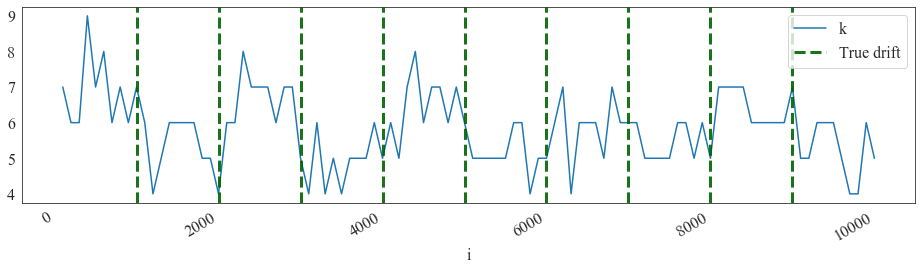

y_pred
Silhouette


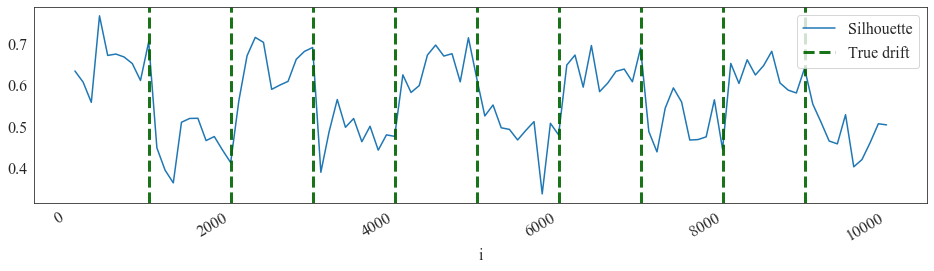

DBi


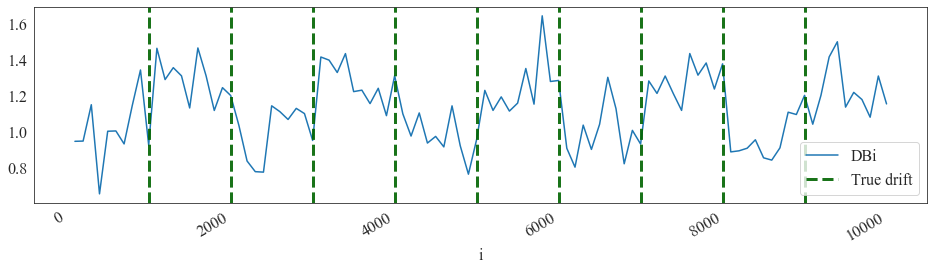

calinski_harabasz_score


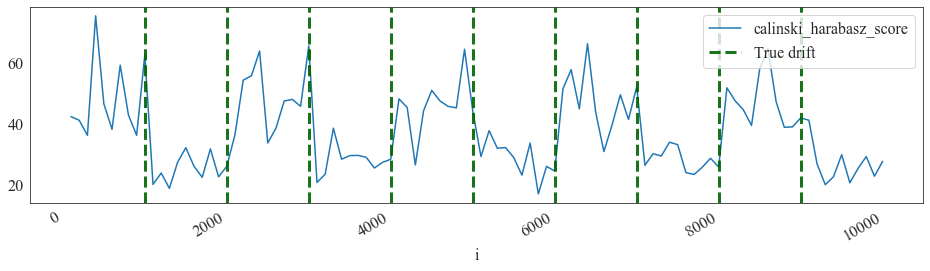

validity_index


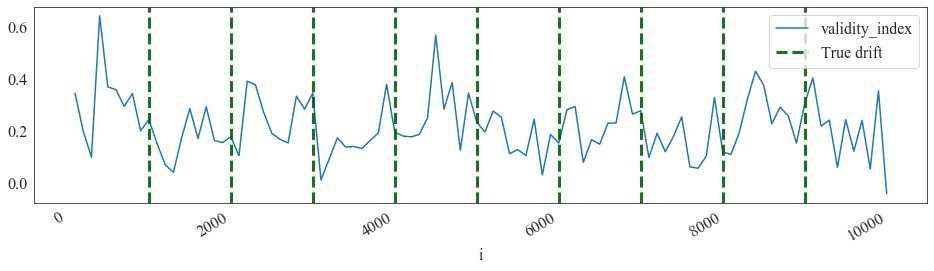

centroids
avg_dist_between_centroids


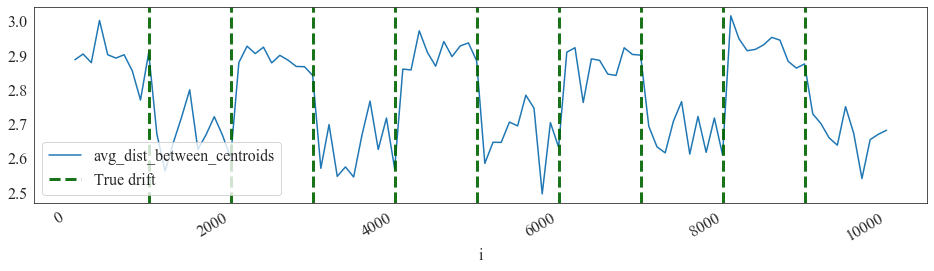

std_dist_between_centroids


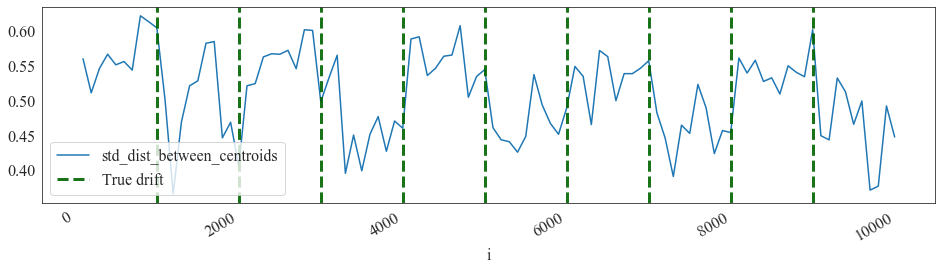

volume_list
radius_list
dist_intra_cluster_list
skewness_list
cluster_std_list
relative_validity


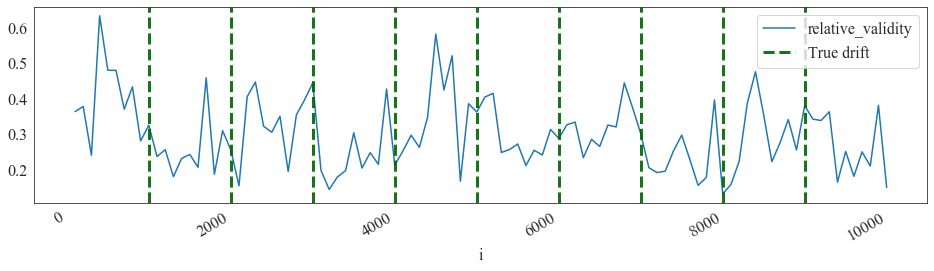

avg_radius


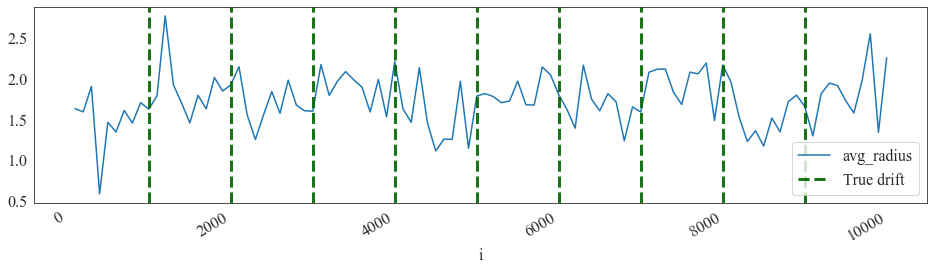

std_radius


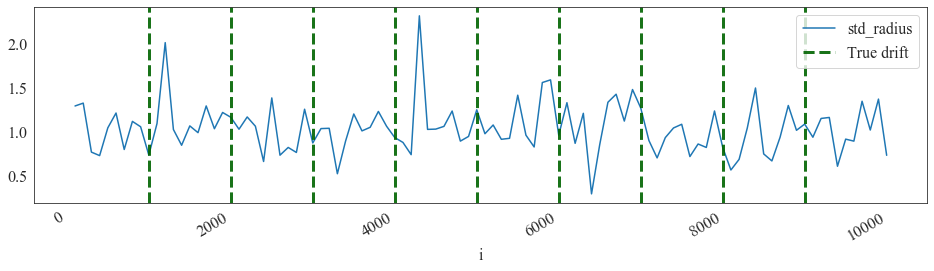

avg_dist_intra_cluster


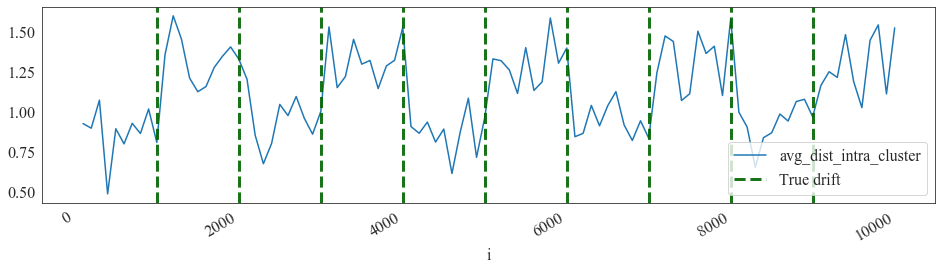

std_dist_intra_cluster


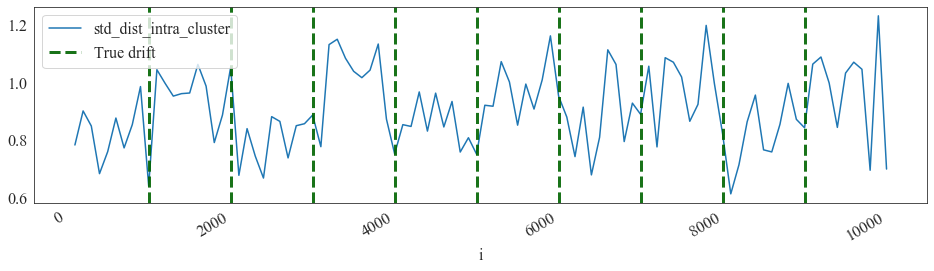

avg_skewness


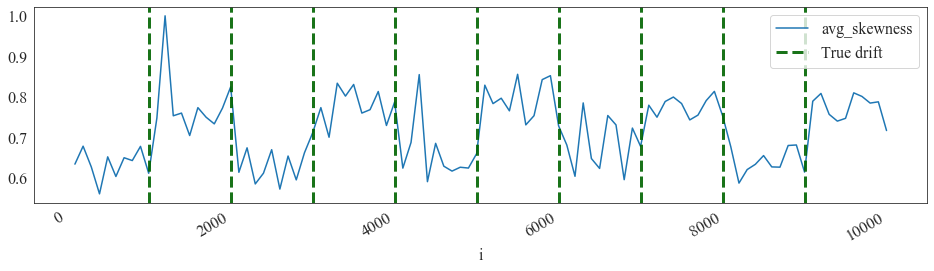

std_skewness


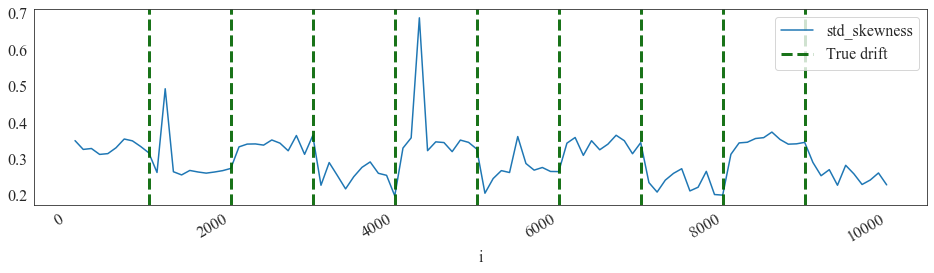

avg_cluster_std


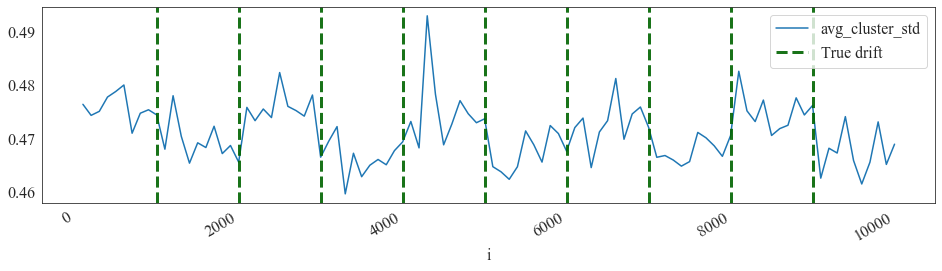

std_cluster_std


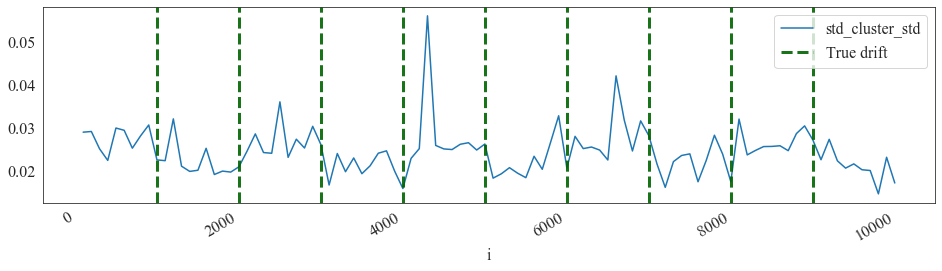

diff_k


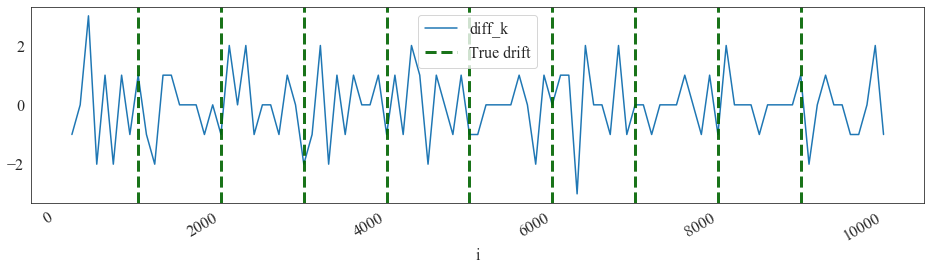

adjusted_rand_score


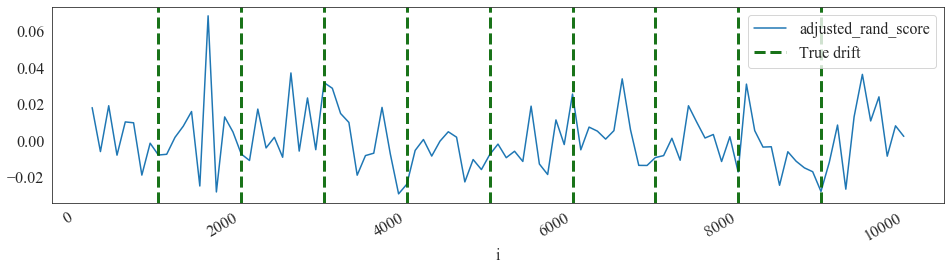

adjusted_mutual_info_score


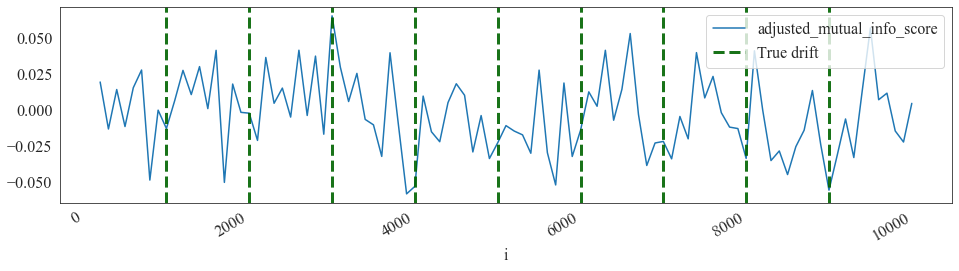

homogeneity_score


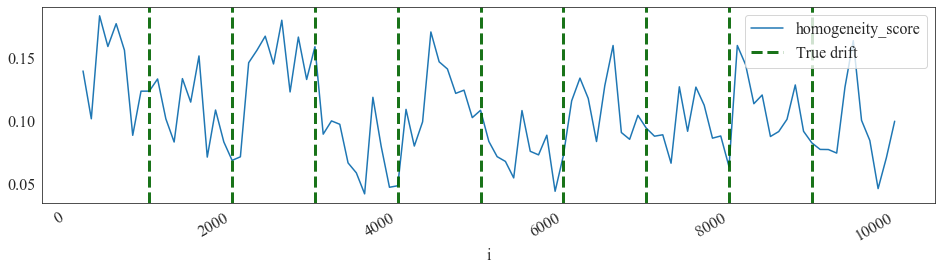

completeness_score


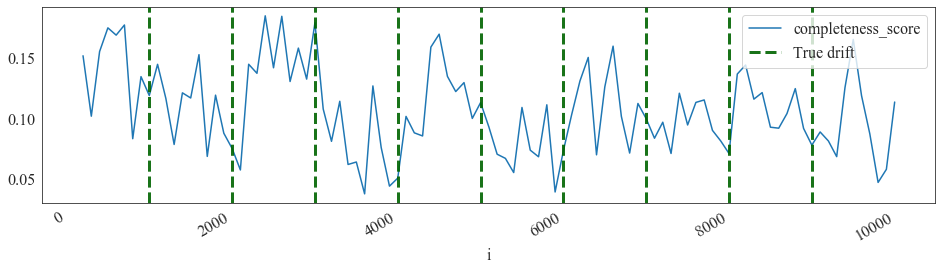

v_measure_score


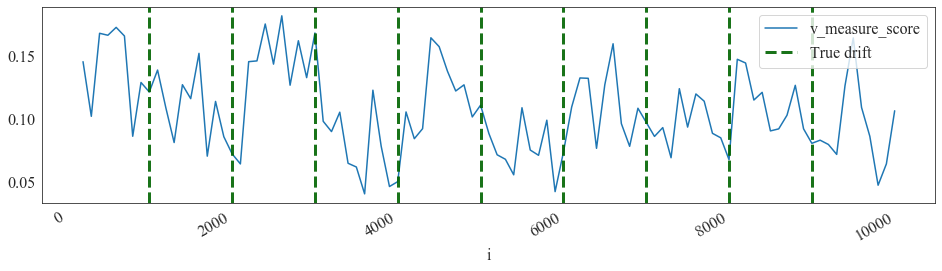

fowlkes_mallows_score


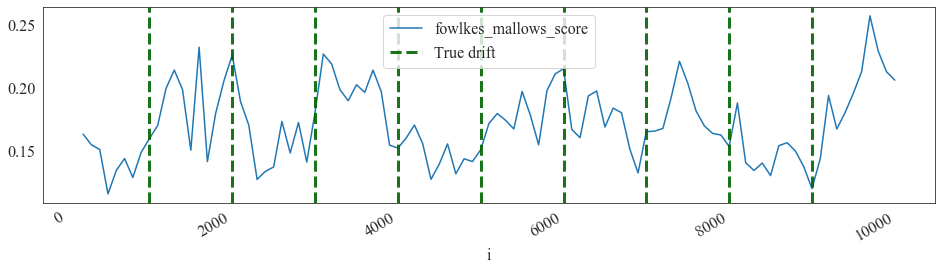

diff_Silhouette


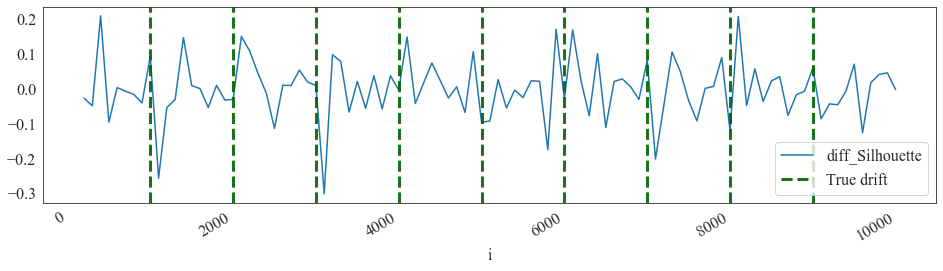

diff_DBi


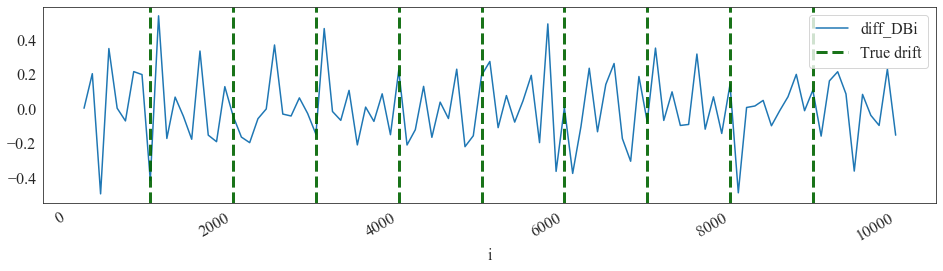

diff_calinski_harabasz_score


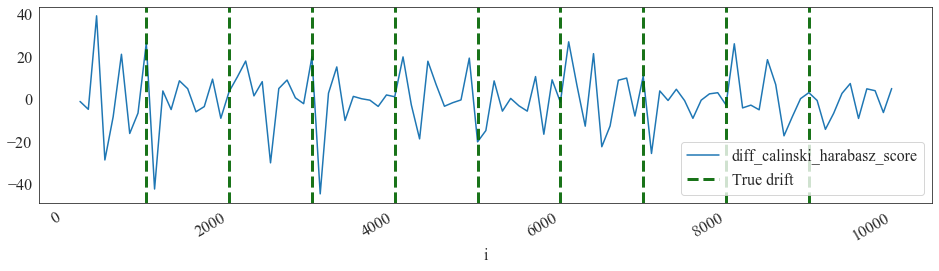

diff_validity_index


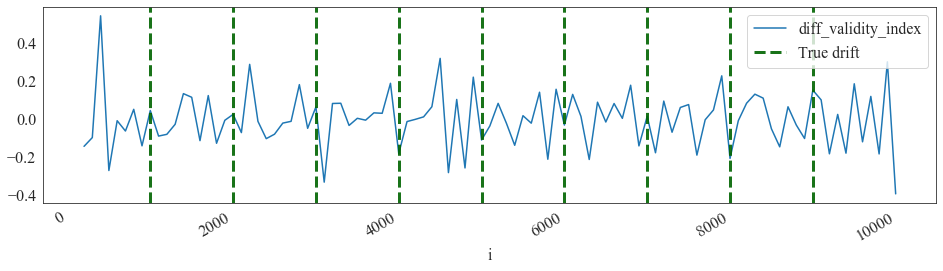

diff_centroids


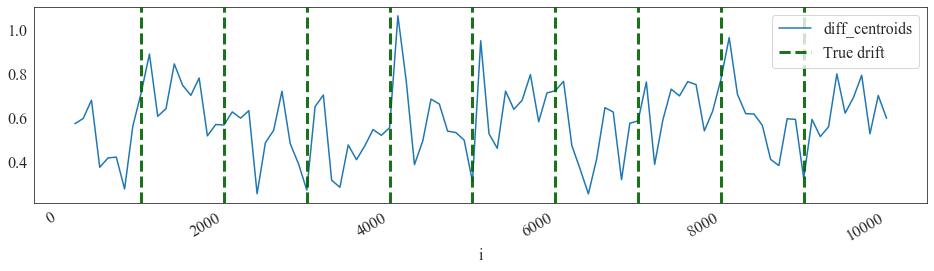

std_diff_centroids


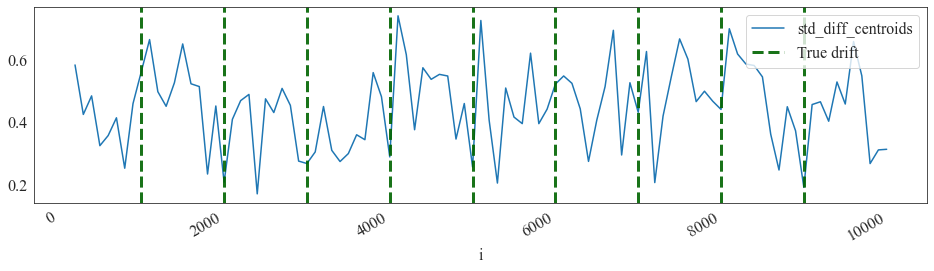

diff_avg_dist_between_centroids


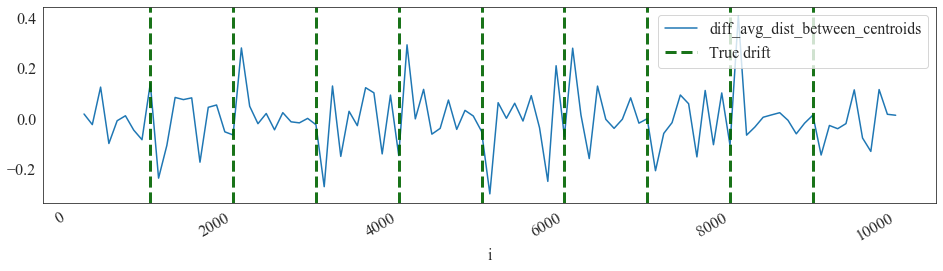

diff_std_dist_between_centroids


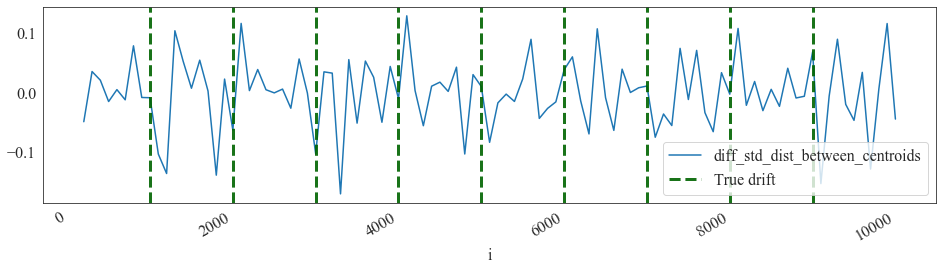

diff_relative_validity


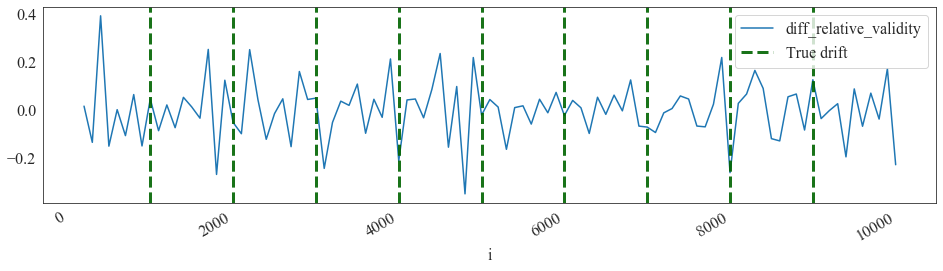

total_MSE


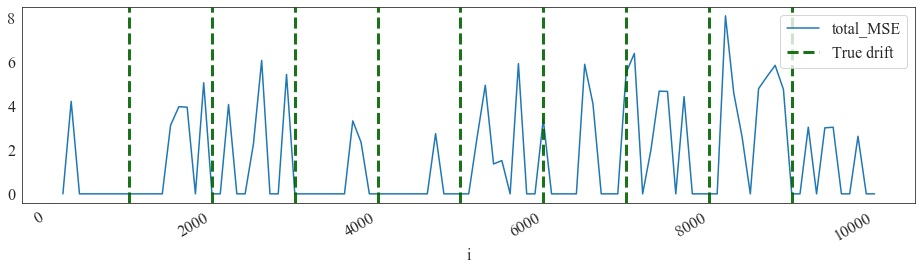

avg_MSE


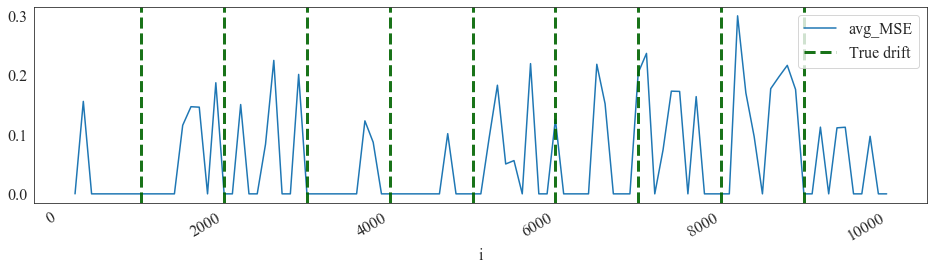

count_non_zero_MSE


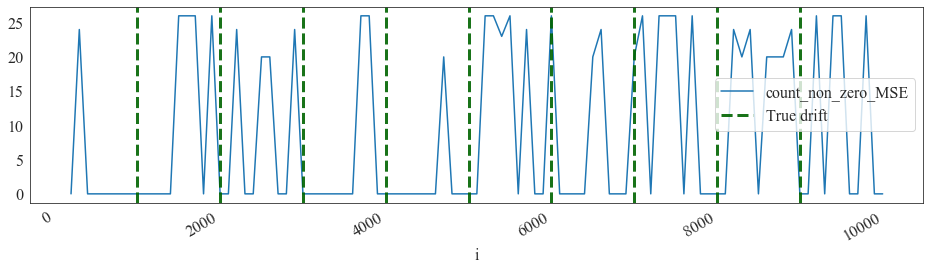

diff_volume
diff_radius


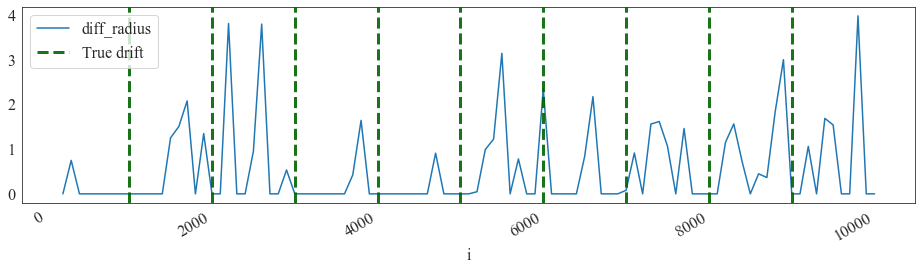

diff_dist_intra_cluster


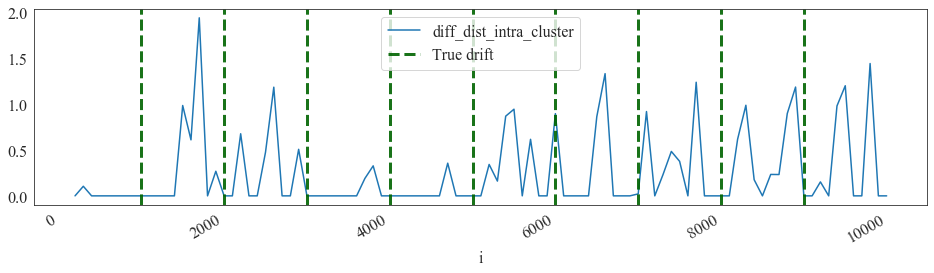

diff_skewness


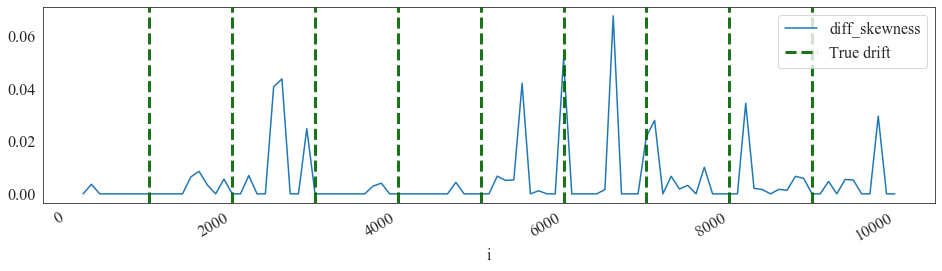

diff_cluster_std


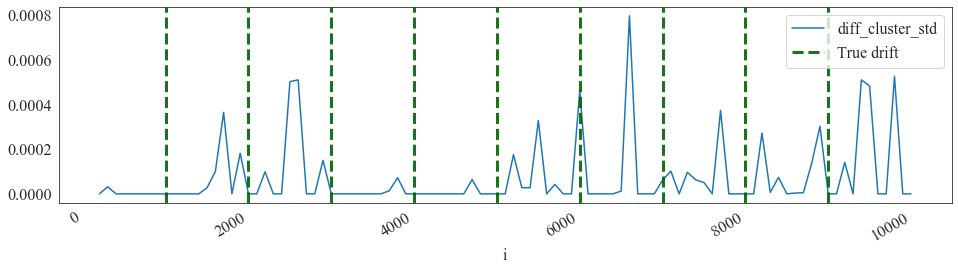

In [43]:
for i in run_df.columns:
    print(i)
    try:
        run_df[i].plot(figsize=(16,4),subplots=True)
        plts.plot_drift_vertical_lines(len(vector_representation), label="True drift")
        plt.legend()
        plt.show()
    except:
        pass

### Drift Detection

In [ ]:
# metric = "avg_dist_between_centroids"
metric = "calinski_harabasz_score"
# metric= "k"

drifts, info = dd.detect_concept_drift(
    run_df,
    metric,
    rolling_window=6,
    std_tolerance=3,
    min_tol=0.05
)

dd.get_metrics(drifts, y_true, window_size=clustering_window_size)

In [ ]:
plts.plot_deteccao_drift(
    run_df,
    metric,
    drifts,
    y_true,
    info['means'],
    info['lowers'],
    info['uppers'],
    save_png=""
)

### Drift Localization

In [ ]:
dl.localize_drift(
    run_df.centroids.loc[500], 
    run_df.centroids.loc[625], 
    activity_binary.columns
)

In [ ]:
# Result of drift localization in the ground truth drifts

dl.localize_all_drifts(
    run_df,
    [x + clustering_window_size for x in y_true], 
    clustering_window_size,
    activity_binary.columns
)

In [ ]:
# Result of drift localization in all predicted drifts

dl.localize_all_drifts(
    run_df,
    drifts, 
    clustering_window_size,
    activity_binary.columns
)